In [349]:
import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import gc
gc.collect()


%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None

In [350]:
ls

data/  forexeda.ipynb  getdata/  models/  README.md  resources/


In [351]:
df = pd.read_pickle('data/EUR_USD_H8')
df.set_index('time', inplace=True)
df.shape

(10764, 6)

In [352]:
df.head()

,volume,close,high,low,open,complete
time,,,,,,
2005-01-02 14:00:00,303,1.35525,1.35700,1.35410,1.35600,True
2005-01-02 22:00:00,8875,1.34455,1.35815,1.33855,1.35535,True
2005-01-03 06:00:00,14773,1.34775,1.35730,1.34455,1.34455,True
2005-01-03 14:00:00,14394,1.34650,1.35030,1.34395,1.34775,True
2005-01-03 22:00:00,2927,1.34920,1.34960,1.34560,1.34650,True


In [353]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10764 entries, 2005-01-02 14:00:00 to 2017-09-08 13:00:00
Data columns (total 6 columns):
volume      10764 non-null int64
close       10764 non-null float64
high        10764 non-null float64
low         10764 non-null float64
open        10764 non-null float64
complete    10764 non-null bool
dtypes: bool(1), float64(4), int64(1)
memory usage: 515.1 KB


In [354]:
def plot_price(price_series, figtitle):
    fig, ax = plt.subplots(figsize=(25,10))
    ax.plot(price_series)
    ax.set_title(figtitle)    

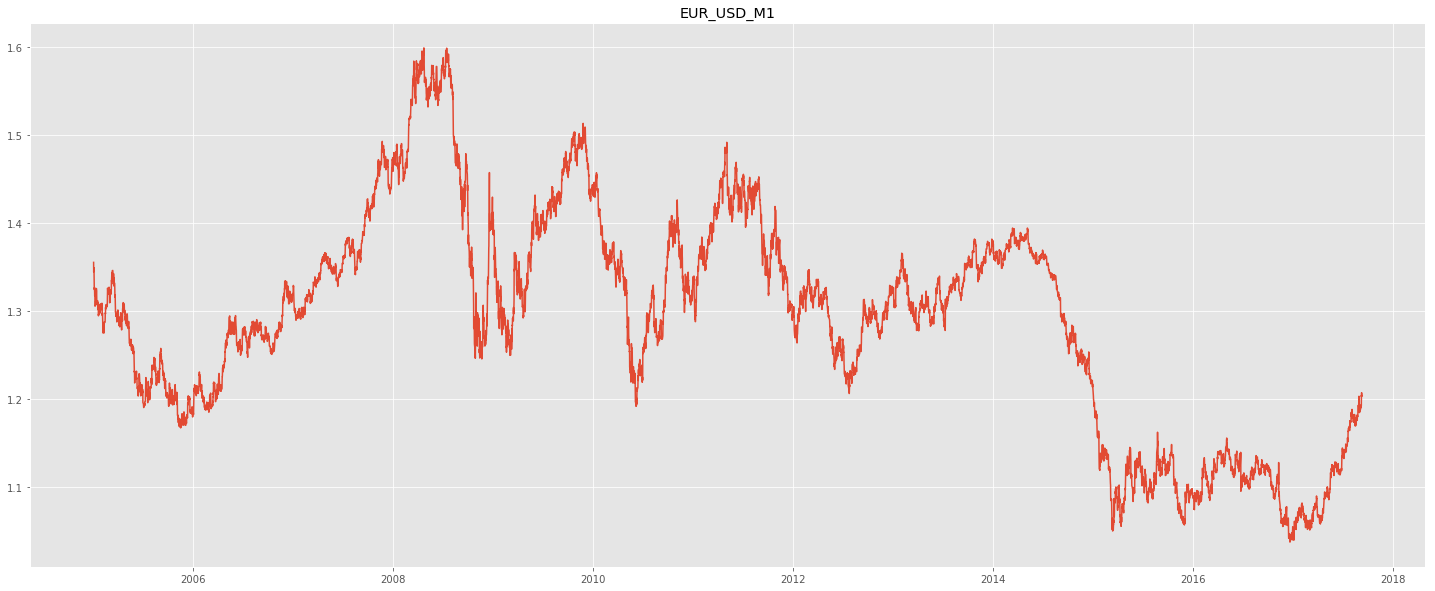

In [355]:
plot_price(df['close'], 'EUR_USD_M1')

In [356]:
# df = df.loc[datetime(2016,6,1):datetime(2017,6,1)]
# df.shape

In [357]:
close_prices = df['close'].values.reshape(-1,1)
close_prices.shape

(10764, 1)

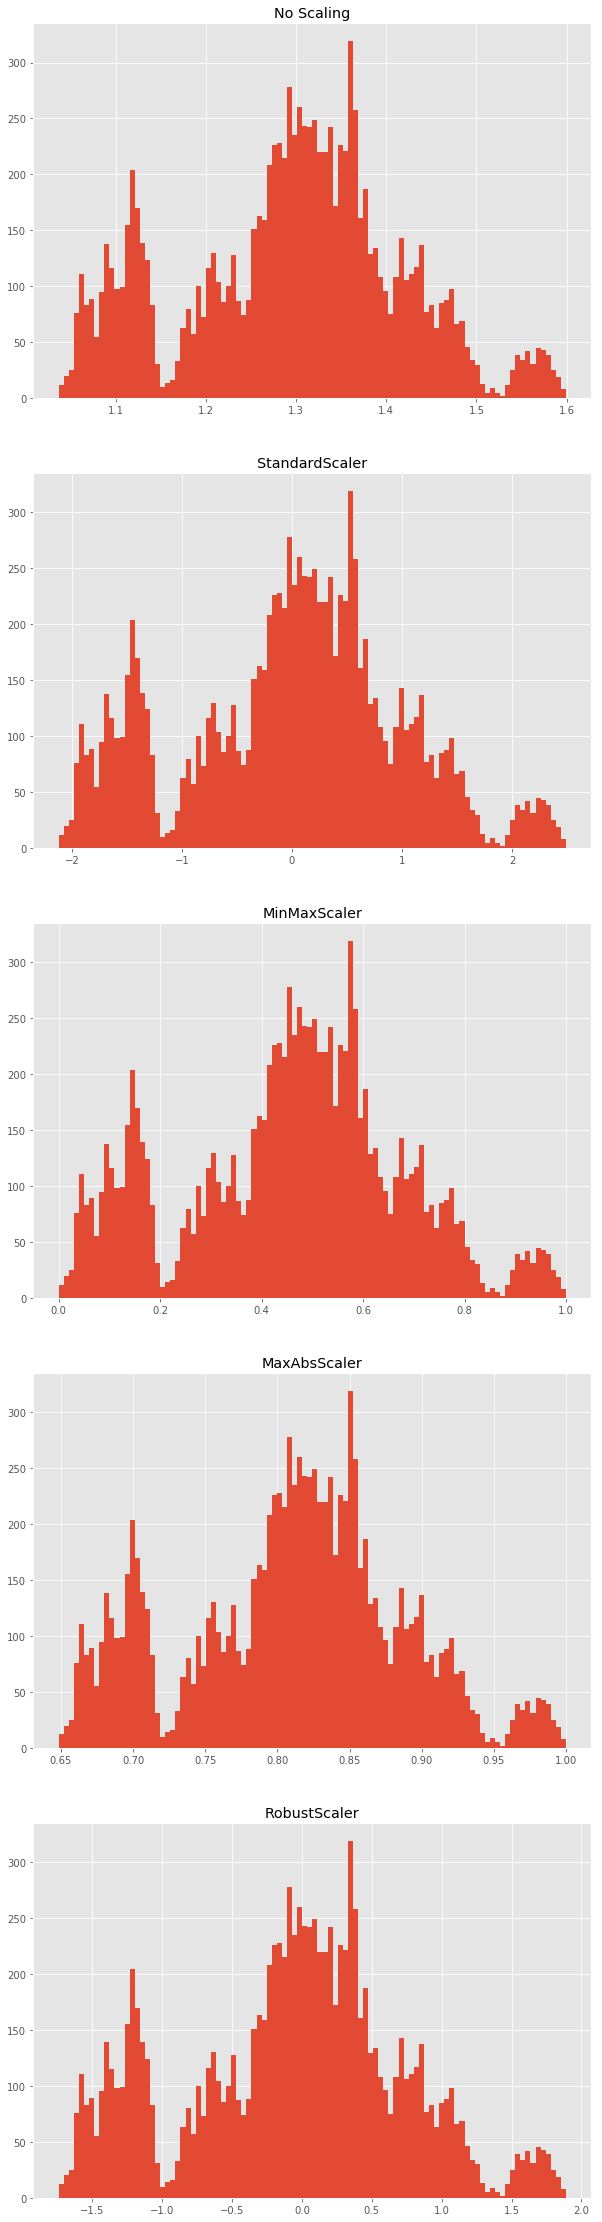

In [358]:
sc, mm, ma, rs = StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()
scalers = [sc, mm, ma, rs]
fig, axes = plt.subplots(len(scalers)+1, 1, figsize=(10,40))
for i, ax in enumerate(axes.reshape(-1)):
    if i == 0:
        ax.hist(close_prices, bins=100)
        ax.set_title('No Scaling')
    else:
        scale = scalers[i-1]
        close_prices_scaled = scale.fit_transform(close_prices)
        ax.hist(close_prices_scaled, bins=100)
        ax.set_title(scale.__class__.__name__)

# Add Target for Classification (Up / Down)

target of i day is the np.sign((open i+d) - (open i))

Exponentially smooth data before calculating features?

In [359]:
# df = pd.read_pickle('data/EUR_USD_H12')
# df.set_index('time', inplace=True)
# df.shape
# df.head()

In [360]:
def up_down(row):
    if row >= 0:
        return 1
    else:
        return 0

In [361]:
#df['actual_up_down'] = np.sign(df['open']-df['open'].shift(1))
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
df['ari_returns'] = (df['close'] / df['close'].shift(1)) - 1
df['log_returns_shifted'] = np.log(df['close'].shift(-1) / df['close'])
df['target_label_direction_shifted'] = df['log_returns_shifted'].apply(up_down)

In [362]:
df.head()

,volume,close,high,low,open,complete,log_returns,ari_returns,log_returns_shifted,target_label_direction_shifted
time,,,,,,,,,,
2005-01-02 14:00:00,303,1.35525,1.35700,1.35410,1.35600,True,NaN,NaN,-0.007927,0
2005-01-02 22:00:00,8875,1.34455,1.35815,1.33855,1.35535,True,-0.007927,-0.007895,0.002377,1
2005-01-03 06:00:00,14773,1.34775,1.35730,1.34455,1.34455,True,0.002377,0.002380,-0.000928,0
2005-01-03 14:00:00,14394,1.34650,1.35030,1.34395,1.34775,True,-0.000928,-0.000927,0.002003,1
2005-01-03 22:00:00,2927,1.34920,1.34960,1.34560,1.34650,True,0.002003,0.002005,-0.008874,0


In [364]:
np.log(1.34455/1.35525)

-0.0079265545770773362

In [365]:
df.tail()

,volume,close,high,low,open,complete,log_returns,ari_returns,log_returns_shifted,target_label_direction_shifted
time,,,,,,,,,,
2017-09-07 05:00:00,53597,1.20422,1.20534,1.19144,1.19242,True,0.009864,0.009913,-0.001504,0
2017-09-07 13:00:00,38475,1.20241,1.20594,1.19729,1.20428,True,-0.001504,-0.001503,0.003777,1
2017-09-07 21:00:00,19633,1.20696,1.20901,1.20170,1.20241,True,0.003777,0.003784,-0.002273,0
2017-09-08 05:00:00,38961,1.20422,1.20928,1.20347,1.20696,True,-0.002273,-0.002270,-0.000573,0
2017-09-08 13:00:00,21289,1.20353,1.20510,1.20150,1.20425,True,-0.000573,-0.000573,NaN,0


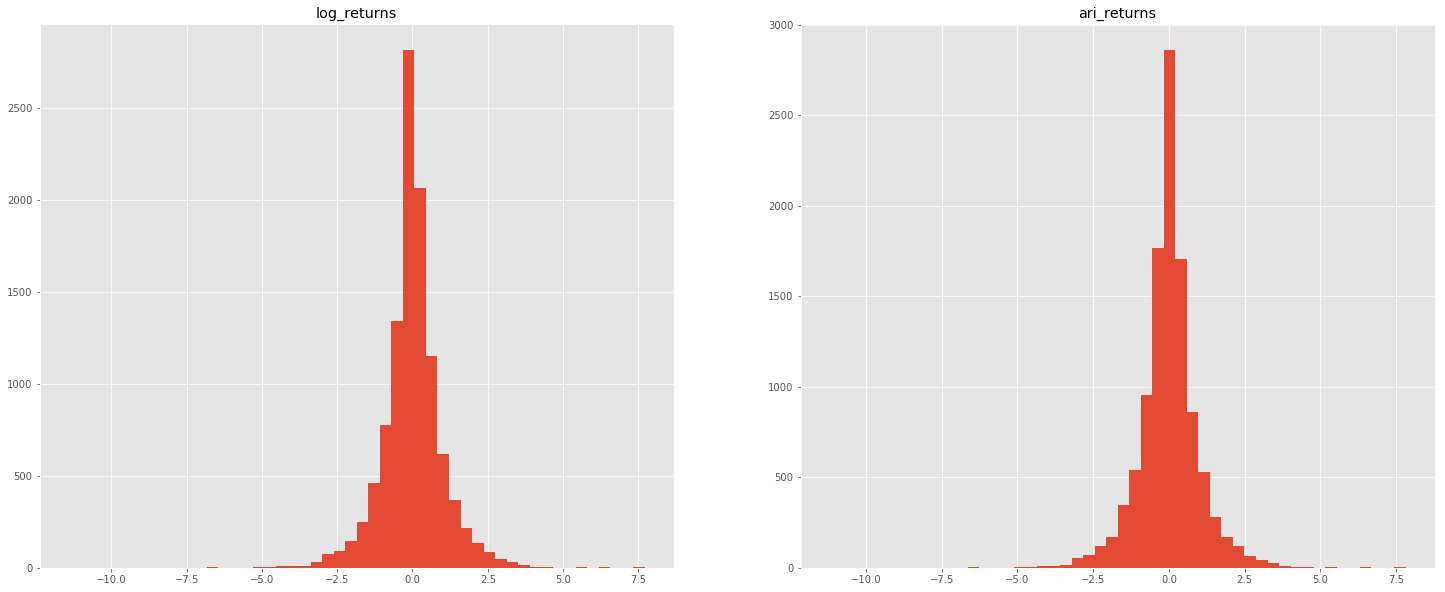

In [366]:
return_types = ['log_returns', 'ari_returns']
fig, axes = plt.subplots(1, len(return_types), figsize=(25,10))
for i, ax in enumerate(axes.reshape(-1)):
    returns = df[return_types[i]].dropna().values.reshape(-1,1)
    returns = StandardScaler().fit_transform(returns)
    ax.hist(returns, bins=50)
    ax.set_title(return_types[i])
plt.show()

# Add Features pandas

In [367]:
# df['20d_ma'] = df['close'].rolling(window=20).mean()
# df['50d_ma'] = df['close'].rolling(window=50).mean()
# df['Bol_upper'] = df['close'].rolling(window=20).mean() + 2* df['close'].rolling(window=20, min_periods=20).std()
# df['Bol_lower'] = df['close'].rolling(window=20).mean() - 2* df['close'].rolling(window=20, min_periods=20).std()
# df['Bol_BW'] = ((df['Bol_upper'] - df['Bol_lower'])/df['20d_ma'])*100
# df['Bol_BW_200MA'] = df['Bol_BW'].rolling(window=50).mean()
# df['20d_exma'] = df['close'].ewm(span=20).mean()
# df['50d_exma'] = df['close'].ewm(span=50).mean()

In [368]:
# df.plot(y=['close','20d_ma','50d_ma','Bol_upper','Bol_lower'], figsize=(25,10))

In [369]:
# df.plot(y=['close', '20d_exma','50d_exma'], figsize=(25,10))

In [370]:
# df.plot(y=['Bol_BW','Bol_BW_200MA'], figsize=(25,10))

# Add Features TA-Lib

In [371]:
print(talib.get_function_groups().keys())

dict_keys(['Cycle Indicators', 'Math Operators', 'Math Transform', 'Momentum Indicators', 'Overlap Studies', 'Pattern Recognition', 'Price Transform', 'Statistic Functions', 'Volatility Indicators', 'Volume Indicators'])


In [372]:
print(talib.get_functions())

['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ADD', 'DIV', 'MAX', 'MAXINDEX', 'MIN', 'MININDEX', 'MINMAX', 'MINMAXINDEX', 'MULT', 'SUB', 'SUM', 'ACOS', 'ASIN', 'ATAN', 'CEIL', 'COS', 'COSH', 'EXP', 'FLOOR', 'LN', 'LOG10', 'SIN', 'SINH', 'SQRT', 'TAN', 'TANH', 'ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR',

In [373]:
talib.abstract.__all__

['Function',
 'DEMA',
 'CDLKICKING',
 'CDLSEPARATINGLINES',
 'EMA',
 'T3',
 'HT_TRENDMODE',
 'ASIN',
 'CDLMATHOLD',
 'MINUS_DI',
 'CDL3BLACKCROWS',
 'SAREXT',
 'MACDEXT',
 'CDLSTICKSANDWICH',
 'HT_DCPERIOD',
 'CDLENGULFING',
 'ADXR',
 'BBANDS',
 'CDLPIERCING',
 'MAX',
 'LN',
 'CDLHIGHWAVE',
 'CDLLONGLINE',
 'HT_DCPHASE',
 'CDL3LINESTRIKE',
 'CDLTHRUSTING',
 'VAR',
 'CDLDRAGONFLYDOJI',
 'CDLCLOSINGMARUBOZU',
 'CDLSTALLEDPATTERN',
 'MULT',
 'TANH',
 'TRIMA',
 'SIN',
 'APO',
 'TYPPRICE',
 'DX',
 'MOM',
 'CDLMATCHINGLOW',
 'ATAN',
 'MINMAXINDEX',
 'MEDPRICE',
 'ACOS',
 'CDLDARKCLOUDCOVER',
 'CDLLONGLEGGEDDOJI',
 'FLOOR',
 'MINMAX',
 'ADD',
 'CDLHAMMER',
 'MACDFIX',
 'CDLSHOOTINGSTAR',
 'EXP',
 'WCLPRICE',
 'CEIL',
 'CDLHARAMI',
 'CDLONNECK',
 'CDLLADDERBOTTOM',
 'CDLUPSIDEGAP2CROWS',
 'CDLSPINNINGTOP',
 'CDL2CROWS',
 'NATR',
 'CDLBREAKAWAY',
 'MIDPOINT',
 'CDLKICKINGBYLENGTH',
 'CDLSHORTLINE',
 'ROCR100',
 'CDLCOUNTERATTACK',
 'ROCR',
 'SQRT',
 'CDLIDENTICAL3CROWS',
 'CDLGRAVESTONEDOJI',
 

In [374]:
ohlcv = {
    'open': df['open'].values,
    'high': df['high'].values,
    'low': df['low'].values,
    'close': df['close'].values,
    'volume': df['volume'].values.astype(float)
}

In [375]:
talib_abstract_fun_list = talib.abstract.__all__[1:]
talib_abstract_fun_list = [i for i in talib_abstract_fun_list if i not in ['MAVP','ASIN', 'ACOS']]
print(len(talib_abstract_fun_list))

155


In [376]:
talib_abstract_fun_list = ['RSI', 'STOCH', 'WILLR', 'ATR', 'MACD', 'BBANDS']

In [377]:
for fun in talib_abstract_fun_list:
    res = getattr(talib.abstract, fun)(ohlcv)
    if len(res) > 10:
        df[fun] = res
    else:
        for i, val in enumerate(res):
            df[fun+'_'+str(i+1)] = val

In [378]:
for per in [3,6,12,18,25]:
    col_name = 'MAVP_'+str(per)
    df[col_name] = talib.MAVP(df['close'].values, periods=np.array([float(per)]*df.shape[0]))

In [379]:
df.head(30)

,volume,close,high,low,open,complete,log_returns,ari_returns,log_returns_shifted,target_label_direction_shifted,RSI,STOCH_1,STOCH_2,WILLR,ATR,MACD_1,MACD_2,MACD_3,BBANDS_1,BBANDS_2,BBANDS_3,MAVP_3,MAVP_6,MAVP_12,MAVP_18,MAVP_25
time,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-01-02 14:00:00,303,1.35525,1.35700,1.35410,1.35600,True,NaN,NaN,-0.007927,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-02 22:00:00,8875,1.34455,1.35815,1.33855,1.35535,True,-0.007927,-0.007895,0.002377,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-03 06:00:00,14773,1.34775,1.35730,1.34455,1.34455,True,0.002377,0.002380,-0.000928,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-03 14:00:00,14394,1.34650,1.35030,1.34395,1.34775,True,-0.000928,-0.000927,0.002003,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-03 22:00:00,2927,1.34920,1.34960,1.34560,1.34650,True,0.002003,0.002005,-0.008874,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.355922,1.348650,1.341378,NaN,NaN,NaN,NaN,NaN
2005-01-04 06:00:00,20195,1.33728,1.34940,1.33512,1.34910,True,-0.008874,-0.008835,-0.006964,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.353410,1.345056,1.336702,NaN,NaN,NaN,NaN,NaN
2005-01-04 14:00:00,19043,1.32800,1.33742,1.32488,1.33728,True,-0.006964,-0.006939,-0.000384,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.357824,1.341746,1.325668,NaN,NaN,NaN,NaN,NaN
2005-01-04 22:00:00,3641,1.32749,1.32909,1.32531,1.32790,True,-0.000384,-0.000384,-0.002421,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.355765,1.337694,1.319623,NaN,NaN,NaN,NaN,NaN
2005-01-05 06:00:00,20754,1.32428,1.32952,1.32152,1.32759,True,-0.002421,-0.002418,0.001358,1,NaN,9.906752,14.703335,NaN,NaN,NaN,NaN,NaN,1.351401,1.333250,1.315099,NaN,NaN,NaN,NaN,NaN


In [380]:
list(df.columns)

['volume',
 'close',
 'high',
 'low',
 'open',
 'complete',
 'log_returns',
 'ari_returns',
 'log_returns_shifted',
 'target_label_direction_shifted',
 'RSI',
 'STOCH_1',
 'STOCH_2',
 'WILLR',
 'ATR',
 'MACD_1',
 'MACD_2',
 'MACD_3',
 'BBANDS_1',
 'BBANDS_2',
 'BBANDS_3',
 'MAVP_3',
 'MAVP_6',
 'MAVP_12',
 'MAVP_18',
 'MAVP_25']

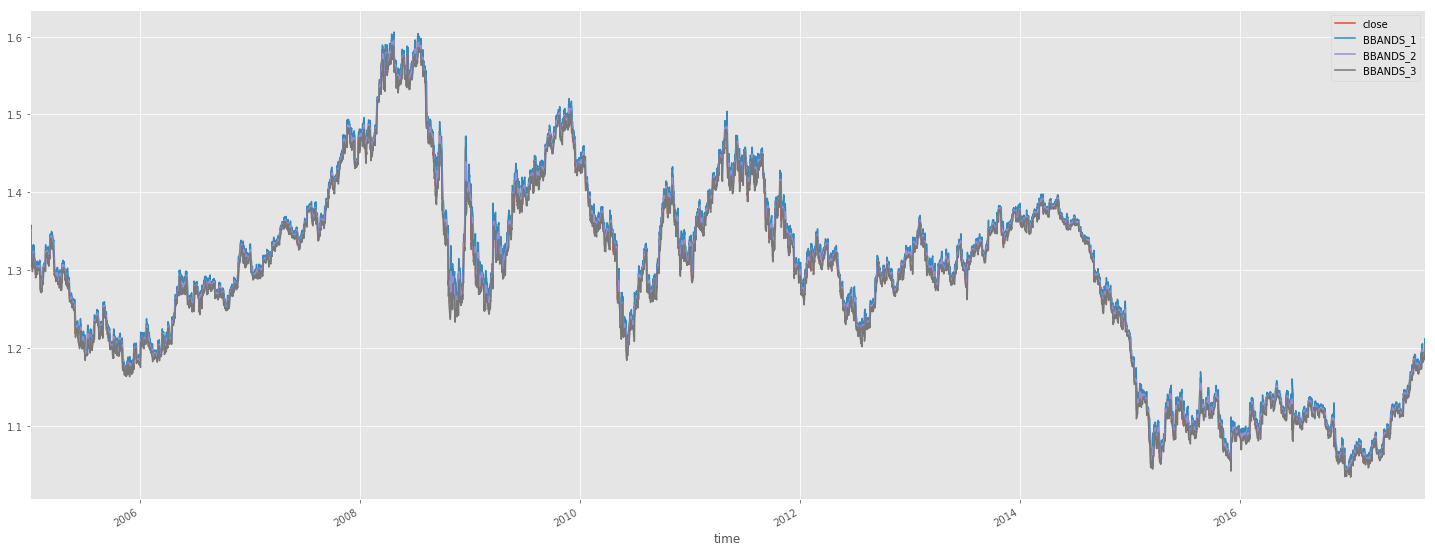

In [381]:
df.plot(y=['close', 'BBANDS_1', 'BBANDS_2', 'BBANDS_3'], figsize=(25,10))

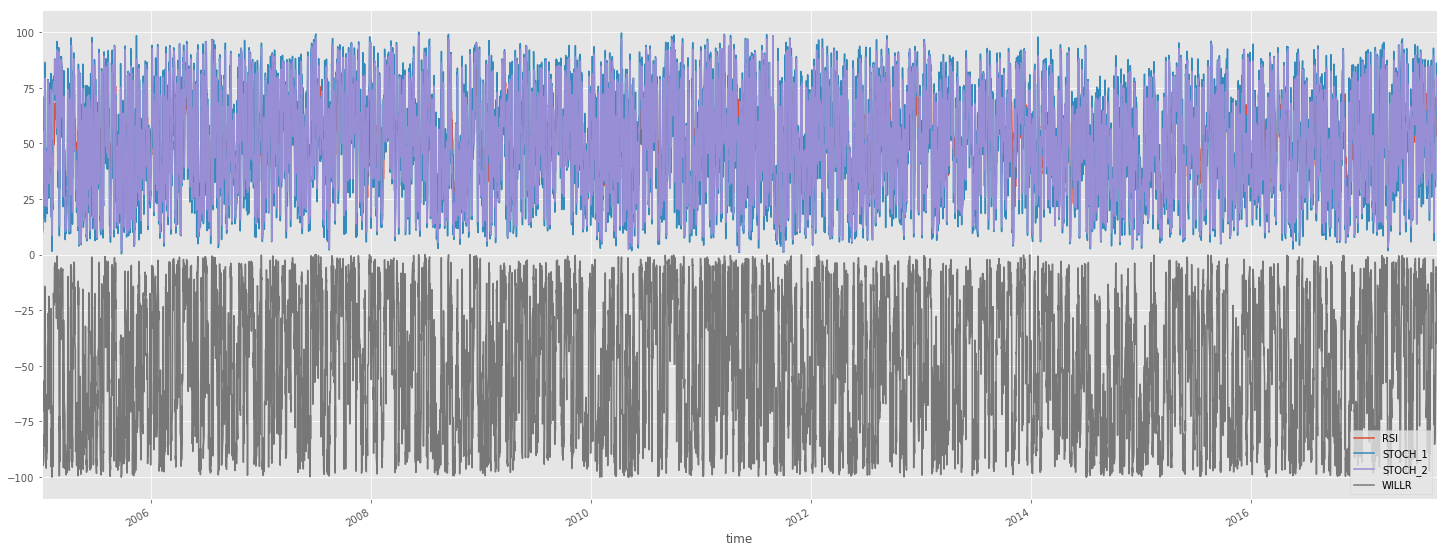

In [382]:
df.plot(y=['RSI', 'STOCH_1', 'STOCH_2','WILLR'], figsize=(25,10))

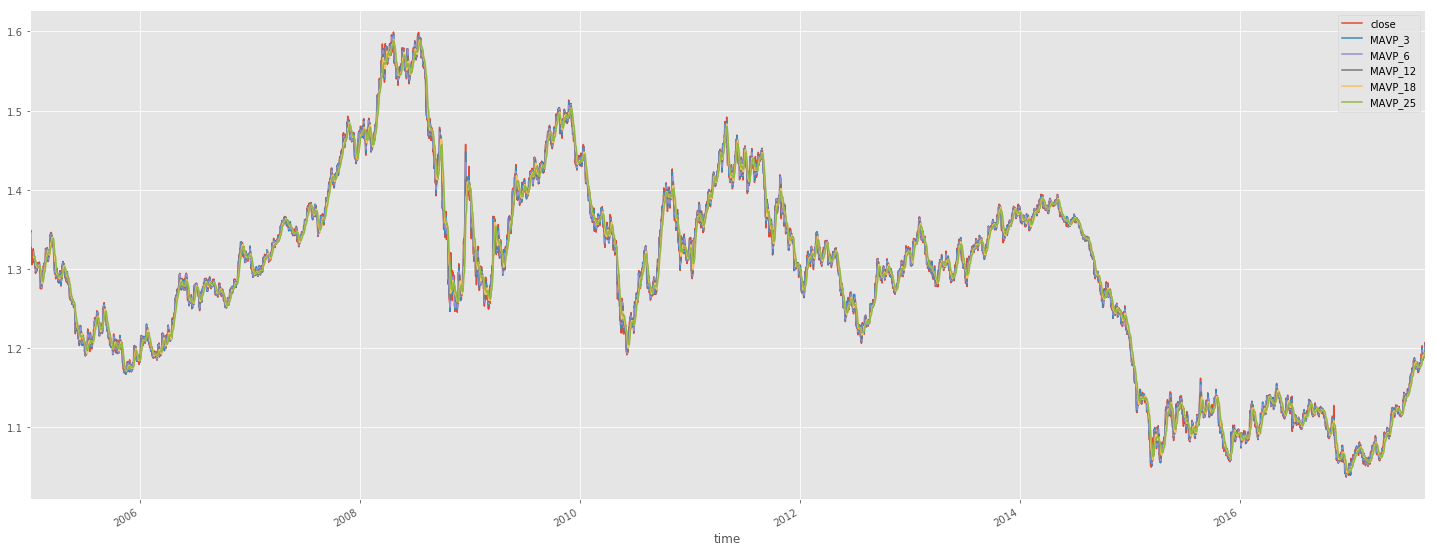

In [383]:
df.plot(y=['close', 'MAVP_3','MAVP_6','MAVP_12','MAVP_18','MAVP_25'], figsize=(25,10))

In [384]:
# for col in df.columns:
#     if df[col].isnull().all():
#         print(col)
#         df.drop(col, axis=1, inplace=True)
# df.drop(['ASIN', 'ACOS'],axis=1, inplace=True)

In [385]:
df.shape[0] - df.dropna().shape[0]

34

In [386]:
drop_columns = ['volume', 'close', 'high', 'low', 'open', 'complete', 'log_returns', 'ari_returns', 'log_returns_shifted', 'target_label_direction_shifted']
predict_columns = [i for i in df.columns if i not in drop_columns]
print(predict_columns)

['RSI', 'STOCH_1', 'STOCH_2', 'WILLR', 'ATR', 'MACD_1', 'MACD_2', 'MACD_3', 'BBANDS_1', 'BBANDS_2', 'BBANDS_3', 'MAVP_3', 'MAVP_6', 'MAVP_12', 'MAVP_18', 'MAVP_25']


In [387]:
df.dropna(inplace=True)

In [388]:
df.shape

(10730, 26)

In [445]:
sv = make_pipeline(StandardScaler(),SVC())
lr = make_pipeline(StandardScaler(), LogisticRegression())
dt = make_pipeline(StandardScaler(), DecisionTreeClassifier())
rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500))
ad = make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators=500))
gb = make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=500))
# sv = SVC()
# lr = LogisticRegression()
# dt = DecisionTreeClassifier()
# rf = RandomForestClassifier(n_jobs=-1)
# ad = AdaBoostClassifier()
# gb = GradientBoostingClassifier()
models = [lr, dt, rf, ad, gb]

In [390]:
y = df['target_label_direction_shifted']
x = df[predict_columns]
print(x.shape, y.shape)

(10730, 16) (10730,)


In [391]:
up = sum(y == 1) / len(y) * 100
print('up: {:.2f}%\ndown: {:.2f}%'.format(up, 100-up))

up: 51.00%
down: 49.00%


In [392]:
for mod in models:
    print(mod.steps[1][1].__class__.__name__)
    #print(mod.__class__.__name__)
    print(np.mean(cross_val_score(mod, x, y, cv=3, n_jobs=-1)))

LogisticRegression
0.505963847032
DecisionTreeClassifier
0.49412709983
RandomForestClassifier
0.481825272783
AdaBoostClassifier
0.494500972219
GradientBoostingClassifier
0.490586817302


In [393]:
# x_train, x_test, y_train, y_test = train_test_split(x, y)
# print(x_train.shape, x_test.shape)
# print(y_train.shape, y_test.shape)

In [446]:
split_index = int(df.shape[0]*.5)
x_train, x_test = x.iloc[:split_index], x.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(5365, 16) (5365, 16)
(5365,) (5365,)


In [447]:
y_test = pd.Series(y_test.values)

In [448]:
for mod in models:
    mod.fit(x_train, y_train)

In [449]:
prediction_df = df[['log_returns']][split_index:]
print(type(prediction_df))
prediction_df.head()

<class 'pandas.core.frame.DataFrame'>


,log_returns
time,
2011-03-14 21:00:00,-0.004893
2011-03-15 05:00:00,-0.002164
2011-03-15 13:00:00,0.007479
2011-03-15 21:00:00,-0.001881
2011-03-16 05:00:00,-0.000408


In [450]:
for mod in models:
    mod_name = mod.steps[1][1].__class__.__name__
    #mod_name = mod.__class__.__name__)
    print(mod_name)
    print('----------------------------')
    print('accuracy', mod.score(x_test, y_test))
    print('----------------------------')
    y_pred = mod.predict(x_test)
    prediction_df[mod_name] = y_pred
    y_pred = pd.Series(y_pred, name='pred')
    print('recall', recall_score(y_test, y_pred))
    print('----------------------------')
    print('precision', precision_score(y_test, y_pred))
    print('----------------------------')
    print(pd.crosstab(y_test, y_pred))
    print('----------------------------')
    print(classification_report(y_test, y_pred))
    print('----------------------------')

LogisticRegression
----------------------------
accuracy 0.513699906803
----------------------------
recall 0.799485861183
----------------------------
precision 0.513443396226
----------------------------
pred     0     1
row_0           
0      579  2063
1      546  2177
----------------------------
             precision    recall  f1-score   support

          0       0.51      0.22      0.31      2642
          1       0.51      0.80      0.63      2723

avg / total       0.51      0.51      0.47      5365

----------------------------
DecisionTreeClassifier
----------------------------
accuracy 0.511090400746
----------------------------
recall 0.529930224018
----------------------------
precision 0.517946877243
----------------------------
pred      0     1
row_0            
0      1299  1343
1      1280  1443
----------------------------
             precision    recall  f1-score   support

          0       0.50      0.49      0.50      2642
          1       0.52      0.53   

LogisticRegression 0.505171273501
DecisionTreeClassifier 0.510801599518
RandomForestClassifier 0.496658194987
AdaBoostClassifier 0.523457340295
GradientBoostingClassifier 0.517758139025


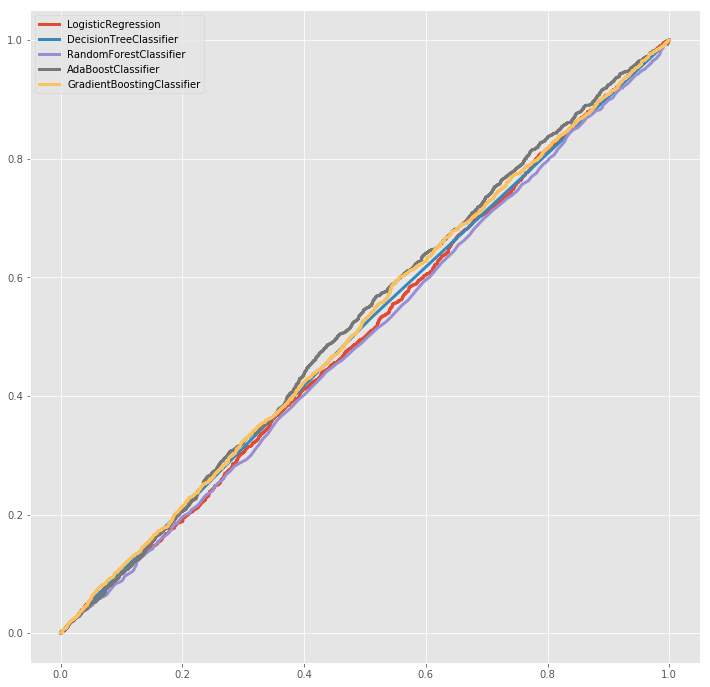

In [451]:
for classer in models:
    probas = classer.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
    roc_auc = auc(fpr, tpr)
    #classer_name = classer.__class__.__name__
    classer_name = classer.steps[1][1].__class__.__name__
    print(classer_name, roc_auc)
    plt.plot(fpr, tpr, lw=3, label=classer_name)
plt.legend(loc='best')

In [452]:
for classer in models[2:]:
    feat_impor = classer.steps[1][1].feature_importances_
    x_feat = pd.DataFrame({'cols': x.columns, 'feat_impo': feat_impor})
    classer_name = classer.__class__.__name__
    print(classer_name, '\n', x_feat.sort_values(by='feat_impo', ascending=False))

Pipeline 
         cols  feat_impo
2    STOCH_2   0.078408
3      WILLR   0.078036
1    STOCH_1   0.077628
7     MACD_3   0.076653
4        ATR   0.075629
0        RSI   0.073394
5     MACD_1   0.070092
6     MACD_2   0.069681
8   BBANDS_1   0.054380
10  BBANDS_3   0.053876
11    MAVP_3   0.050516
15   MAVP_25   0.050448
14   MAVP_18   0.049100
13   MAVP_12   0.048423
12    MAVP_6   0.046942
9   BBANDS_2   0.046794
Pipeline 
         cols  feat_impo
6     MACD_2      0.100
7     MACD_3      0.096
2    STOCH_2      0.092
4        ATR      0.082
5     MACD_1      0.078
1    STOCH_1      0.072
10  BBANDS_3      0.068
11    MAVP_3      0.058
14   MAVP_18      0.058
3      WILLR      0.056
15   MAVP_25      0.048
8   BBANDS_1      0.044
13   MAVP_12      0.044
0        RSI      0.040
12    MAVP_6      0.034
9   BBANDS_2      0.030
Pipeline 
         cols  feat_impo
4        ATR   0.121932
1    STOCH_1   0.096442
2    STOCH_2   0.094742
7     MACD_3   0.090976
3      WILLR   0.088637
6     M

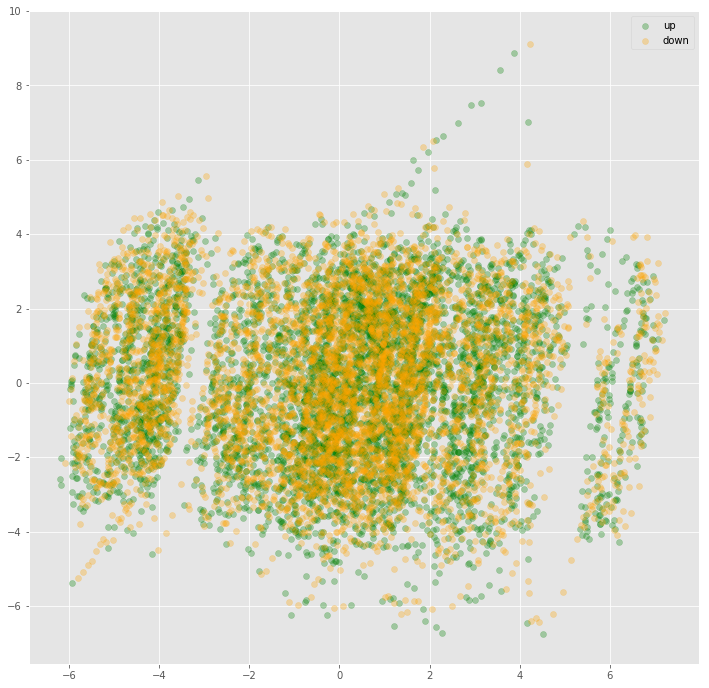

In [453]:
pca = make_pipeline(StandardScaler(), PCA(n_components=2))
x_new = pca.fit_transform(x)
fig, ax = plt.subplots()
x_new_one = x_new[y==1]
x_new_zero = x_new[y==0]
ax.scatter(x_new_one[:,0], x_new_one[:,1], c='green', label='up', alpha=.3)
ax.scatter(x_new_zero[:,0], x_new_zero[:,1], c='orange', label='down', alpha=.3)
plt.legend(loc='best')

In [454]:
model_list = list(prediction_df.columns[1:])
for mod_col in model_list:
    prediction_df[mod_col] = prediction_df[mod_col].map({1:1, 0:-1})

In [455]:
prediction_df.head()

,log_returns,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
time,,,,,,
2011-03-14 21:00:00,-0.004893,1,1,1,1,1
2011-03-15 05:00:00,-0.002164,1,1,1,1,1
2011-03-15 13:00:00,0.007479,1,-1,1,1,1
2011-03-15 21:00:00,-0.001881,1,1,1,1,1
2011-03-16 05:00:00,-0.000408,1,1,1,1,-1


In [466]:
model_returns = ['log_returns']
for mod_col in model_list:
    model_returns.append(mod_col+'_returns')
    prediction_df[mod_col+'_returns'] = prediction_df[mod_col] * prediction_df['log_returns']

In [467]:
prediction_df.head()

,log_returns,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,LogisticRegression_returns,DecisionTreeClassifier_returns,RandomForestClassifier_returns,AdaBoostClassifier_returns,GradientBoostingClassifier_returns
time,,,,,,,,,,,
2011-03-14 21:00:00,-0.004893,1,1,1,1,1,-0.004893,-0.004893,-0.004893,-0.004893,-0.004893
2011-03-15 05:00:00,-0.002164,1,1,1,1,1,-0.002164,-0.002164,-0.002164,-0.002164,-0.002164
2011-03-15 13:00:00,0.007479,1,-1,1,1,1,0.007479,-0.007479,0.007479,0.007479,0.007479
2011-03-15 21:00:00,-0.001881,1,1,1,1,1,-0.001881,-0.001881,-0.001881,-0.001881,-0.001881
2011-03-16 05:00:00,-0.000408,1,1,1,1,-1,-0.000408,-0.000408,-0.000408,-0.000408,0.000408


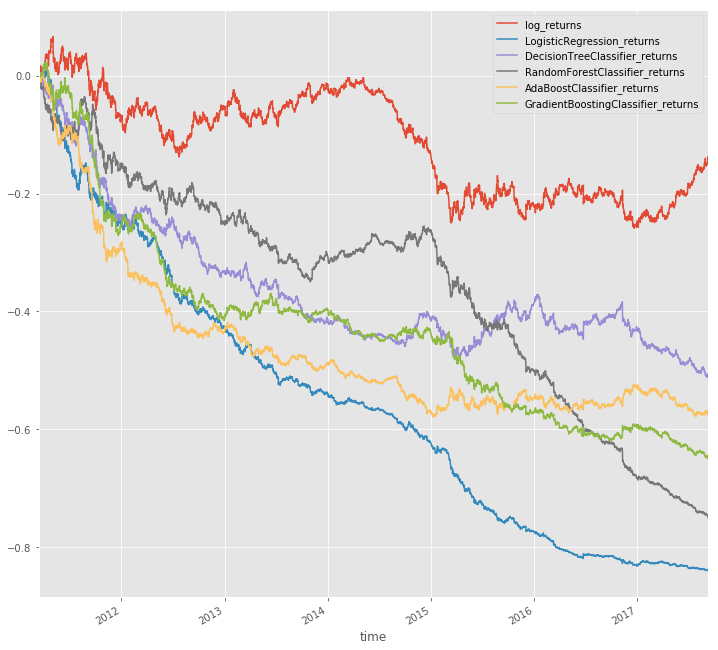

In [468]:
fig, axes = plt.subplots()
cum_returns = prediction_df[model_returns].cumsum().apply(np.exp)-1 #you can add log returns and then transpose back with np.exp
cum_returns.plot(ax=axes)
plt.legend(loc='best')

In [476]:
cols = []
for momentum in [1, 15, 30, 60, 120]:
    col = 'average_log_return_sign_{}'.format(momentum)
    df[col] = np.sign(df['log_returns'].rolling(momentum).mean()) #the sign of the average returns of the last x candles
    cols.append(col)

In [478]:
df.head(20)

,volume,close,high,low,open,complete,log_returns,ari_returns,log_returns_shifted,target_label_direction_shifted,RSI,STOCH_1,STOCH_2,WILLR,ATR,MACD_1,MACD_2,MACD_3,BBANDS_1,BBANDS_2,BBANDS_3,MAVP_3,MAVP_6,MAVP_12,MAVP_18,MAVP_25,average_log_return_sign_15,average_log_return_sign_30,average_log_return_sign_60,average_log_return_sign_120,strategy_average_log_return_sign_15,strategy_average_log_return_sign_30,strategy_average_log_return_sign_60,strategy_average_log_return_sign_120,average_log_return_sign_1
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-01-16 22:00:00,1722,1.31170,1.31190,1.30930,1.31050,True,0.000915,0.000916,-0.001266,0,37.174038,29.385817,22.112555,-74.819839,0.006633,-0.006200,-0.007563,0.001363,1.312608,1.310598,1.308588,1.311100,1.312598,1.316177,1.314106,1.315560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2005-01-17 06:00:00,15667,1.31004,1.31280,1.30824,1.31170,True,-0.001266,-0.001266,-0.002537,0,35.893597,38.577791,30.089905,-81.856719,0.006485,-0.006016,-0.007253,0.001237,1.312431,1.310416,1.308401,1.310747,1.310505,1.316123,1.314319,1.314919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
2005-01-17 14:00:00,7083,1.30672,1.31004,1.30612,1.31004,True,-0.002537,-0.002534,-0.001777,0,33.414627,32.125939,33.363182,-95.930479,0.006302,-0.006068,-0.007016,0.000948,1.313489,1.310012,1.306535,1.309487,1.309800,1.315717,1.314287,1.314116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
2005-01-17 22:00:00,4522,1.30440,1.30742,1.30090,1.30672,True,-0.001777,-0.001775,0.001930,1,31.763730,30.101903,33.601878,-87.697715,0.006317,-0.006225,-0.006858,0.000633,1.314071,1.308672,1.303273,1.307053,1.309077,1.314175,1.313899,1.313547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
2005-01-18 06:00:00,19322,1.30692,1.30748,1.29954,1.30440,True,0.001930,0.001932,-0.003864,0,35.491895,30.953360,31.060401,-75.243207,0.006433,-0.006076,-0.006702,0.000626,1.313141,1.307956,1.302771,1.306013,1.308380,1.312625,1.313877,1.313131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2005-01-18 14:00:00,15002,1.30188,1.30692,1.30048,1.30692,True,-0.003864,-0.003856,0.000706,1,31.755032,34.238311,31.764525,-92.150285,0.006434,-0.006292,-0.006620,0.000328,1.311449,1.305992,1.300535,1.304400,1.306943,1.310673,1.313257,1.312410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
2005-01-18 22:00:00,2193,1.30280,1.30360,1.30110,1.30178,True,0.000706,0.000707,0.005191,1,33.138896,34.783595,33.325089,-87.988209,0.006153,-0.006316,-0.006559,0.000243,1.308598,1.304544,1.300490,1.303867,1.305460,1.309029,1.312604,1.311683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2005-01-19 06:00:00,18787,1.30958,1.31186,1.30090,1.30280,True,0.005191,0.005204,-0.006512,0,42.407517,43.396061,37.472656,-63.006632,0.006496,-0.005722,-0.006392,0.000669,1.310740,1.305116,1.299492,1.304753,1.305383,1.307944,1.312543,1.311850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2005-01-19 14:00:00,18317,1.30108,1.30994,1.29636,1.30958,True,-0.006512,-0.006491,0.000015,1,35.721789,47.664246,41.947968,-82.427401,0.007002,-0.005870,-0.006287,0.000418,1.310970,1.304452,1.297934,1.304487,1.304443,1.307122,1.311959,1.311645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0


In [481]:
strats = ['log_returns']
for col in cols:
    strat = 'strategy_{}'.format(col)
    df[strat] = df[col].shift(1) * df['log_returns'] #shift last sign one and multiply by return
    strats.append(strat)

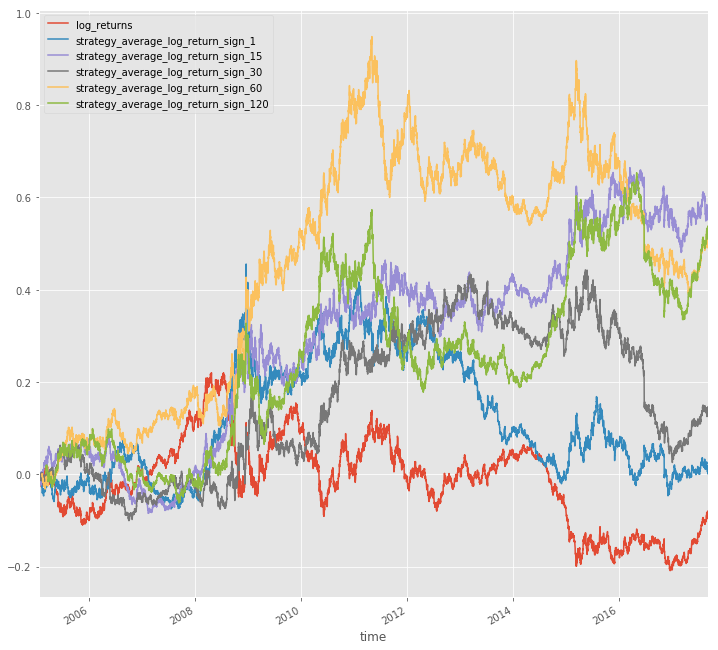

In [482]:
fig, axes = plt.subplots()
cum_returns = df[strats].cumsum().apply(np.exp)-1 #you can add log returns and then transpose back with np.exp
cum_returns.plot(ax=axes)
plt.legend(loc='best')